In [2]:
! pip install --upgrade ta
! pip install vectorbt

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0b13af2d0cd2d43cb5ea1e884b59f461dce11c75ecad1dde09b818b3e508ee4c
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.6 MB/s eta 0:00:00


In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import vectorbt as vbt
import shap
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [15]:
TICKERS = ["ETH-USD", "BTC-USD"]
PERIOD = "8d"
INTERVAL = "1m"

In [16]:
def create_dataframe(ticker, period, interval):return yf.Ticker(ticker).history(period=period, interval=interval)
def add_features(df, ticker):
    # --- Basic Technical Indicators ---
    # Momentum
    df["rsi"] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df["stoch_osc"] = ta.momentum.StochasticOscillator(df["High"], df["Low"], df["Close"]).stoch()
    # Trend
    df['macd'] = ta.trend.MACD(df['Close']).macd()
    df['macd_signal'] = ta.trend.MACD(df['Close']).macd_signal() # Add signal line
    df['macd_diff'] = ta.trend.MACD(df['Close']).macd_diff()     # Add MACD histogram
    df['adx'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close']).adx()
    # Volatility
    bollinger = ta.volatility.BollingerBands(df['Close'])
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_width'] = bollinger.bollinger_wband() # Add bandwidth
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range() # Add ATR
    # Volume
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()

    # 2. Moving Average Slopes (Proxy using difference)
    df['ema_fast'] = ta.trend.EMAIndicator(df['Close'], window=12).ema_indicator() # Faster EMA
    df['ema_slow'] = ta.trend.EMAIndicator(df['Close'], window=26).ema_indicator() # Slower EMA
    df['ema_fast_slope'] = df['ema_fast'].diff()
    df['ema_slow_slope'] = df['ema_slow'].diff()

    # 3. Rate of Change (ROC) of key indicators
    df['rsi_roc'] = df['rsi'].diff() # Simple difference as ROC proxy
    df['macd_diff_roc'] = df['macd_diff'].diff() # How fast is MACD divergence changing?
    return df

def add_target(df):
  df["target"] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
  return df

def train_test_split_chronological(df, test_size=0.2):
    split_idx = int(len(df) * (1 - test_size))
    train, test = df.iloc[:split_idx], df.iloc[split_idx:]
    X_train, y_train = train.drop(columns=['target']), train['target']
    X_test, y_test = test.drop(columns=['target']), test['target']
    return X_train, X_test, y_train, y_test

In [17]:
# --- Plotting Utilities ---
def plot_confusion_matrix_and_metrics(y_true, y_pred, class_names=None, title='Confusion Matrix and Metrics'):
    """Plots confusion matrix and key classification metrics using Plotly."""
    if y_true.empty or len(y_pred) == 0:
        print("Cannot plot confusion matrix: Empty data.")
        return
    if len(y_true) != len(y_pred):
         print(f"Warning: y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths differ. Cannot plot confusion matrix.")
         return

    if class_names is None:
        class_names = ['Down (0)', 'Up (1)']
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5],
                        specs=[[{'type': 'heatmap'}, {'type': 'table'}]],
                        subplot_titles=('Confusion Matrix', 'Metrics'))

    # Heatmap
    fig.add_trace(go.Heatmap(z=cm, x=class_names, y=class_names, colorscale='Blues',
                             text=cm, texttemplate="%{text}", showscale=False),
                  row=1, col=1)

    # Metrics Table
    metrics_table = go.Table(
        header=dict(values=['Metric', 'Value'], fill_color='paleturquoise', align='left'),
        cells=dict(values=[['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                           [f'{m:.4f}' for m in [accuracy, precision, recall, f1]]],
                   fill_color='lavender', align='left'))
    fig.add_trace(metrics_table, row=1, col=2)

    fig.update_layout(title_text=title, height=400, width=800)
    fig.update_xaxes(title_text='Predicted Label', row=1, col=1)
    fig.update_yaxes(title_text='True Label', row=1, col=1)
    fig.show()


def plot_shap_and_importance(model, X_train, X_test, title_suffix=''):
    """Plots SHAP summary plot and standard feature importance."""
    print("Calculating SHAP values for test set...")
    try:
        explainer = shap.TreeExplainer(model)
        shap_values_list = explainer.shap_values(X_test) # This returns a list [shap_class_0, shap_class_1]

        if isinstance(shap_values_list, list) and len(shap_values_list) == 2:
            shap_values_positive_class = shap_values_list[1] # Use SHAP values for the positive class (1)
        else:
            # Handle cases where output might be different (e.g., single array if booster='gblinear')
            print("Warning: SHAP values format unexpected. Using raw output.")
            shap_values_positive_class = shap_values_list

        # Ensure X_test is a DataFrame for plotting with feature names
        if not isinstance(X_test, pd.DataFrame):
            X_test_df = pd.DataFrame(X_test, columns=X_train.columns) # Use train columns order/names
            print("Warning: X_test was not a DataFrame. Converted for SHAP plot.")
        else:
            X_test_df = X_test

        # Check for shape mismatches before plotting
        if shap_values_positive_class.shape[0] != X_test_df.shape[0] or \
           shap_values_positive_class.shape[1] != X_test_df.shape[1]:
            raise ValueError(f"Shape mismatch: SHAP values ({shap_values_positive_class.shape}) vs X_test ({X_test_df.shape})")

        print("Generating SHAP summary plots...")
        plt.close('all') # Close previous matplotlib figures

        # SHAP Summary Plot (Bar plot style)
        plt.figure(figsize=(10, max(6, len(X_test_df.columns) * 0.3))) # Adjust size
        shap.summary_plot(shap_values_positive_class, X_test_df, plot_type="bar", show=False)
        plt.title(f"Feature Impact (Mean Absolute SHAP) {title_suffix}")
        plt.tight_layout()
        plt.show()

        # SHAP Summary Plot (Dot plot style)
        plt.figure(figsize=(10, max(6, len(X_test_df.columns) * 0.3))) # Adjust size
        shap.summary_plot(shap_values_positive_class, X_test_df, show=False)
        plt.title(f"SHAP Value Distribution {title_suffix}")
        plt.tight_layout()
        plt.show()

        print("SHAP plots generated.")

    except Exception as e:
        print(f"Could not generate SHAP plots: {e}")
        import traceback
        traceback.print_exc()

    # --- Standard Feature Importance Plot (from model attribute) ---
    print("Generating LGBM feature importance plot...")
    try:
        # Check if feature_importances_ attribute exists
        if hasattr(model, 'feature_importances_') and model.feature_importances_ is not None:
            importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': model.feature_importances_})\
                            .sort_values('Importance', ascending=True)
            fig = go.Figure(go.Bar(x=importance_df['Importance'], y=importance_df['Feature'], orientation='h'))
            fig.update_layout(title=f'LGBM Feature Importance {title_suffix}', xaxis_title='Importance', yaxis_title='Features',
                              height=max(400, len(importance_df) * 20)) # Adjust height
            fig.show()
            print("LGBM feature importance plot generated.")
        else:
             print("Model does not have feature_importances_ attribute.")
    except Exception as e:
        print(f"Could not generate LGBM importance plot: {e}")


def plot_correlation_matrix(data, title='Feature Correlation Matrix'):
    """ Plots an interactive correlation matrix heatmap using Plotly. """
    numeric_data = data.select_dtypes(include=np.number)
    if numeric_data.empty:
        print("No numeric data found for correlation matrix.")
        return

    corr = numeric_data.corr()
    fig = go.Figure(data=go.Heatmap(
        z=corr.values,
        x=corr.columns,
        y=corr.columns,
        colorscale='RdBu',
        zmin=-1,
        zmax=1,
        text=np.around(corr.values, decimals=2),
        texttemplate="%{text}",
        colorbar=dict(title='Correlation')
    ))
    fig.update_layout(
        title=title,
        xaxis_title='Features',
        yaxis_title='Features',
        width=min(1200, 40 * len(corr.columns)), # Adjust width
        height=min(1000, 40 * len(corr.columns)), # Adjust height
        xaxis=dict(tickangle=-45),
        yaxis=dict(tickangle=0),
        margin=dict(l=100, r=50, b=150, t=100) # Adjust margins for labels
    )
    fig.show()

In [18]:
def backesting(df, init_cash, freq, size, size_type, fees, slippage):
  portfolio = vbt.Portfolio.from_signals(
    close=df["Close"],
    entries=df["signal"] == 1,
    exits=df["signal"] == -1,
    init_cash=init_cash,
    freq=freq,
    size=size,
    size_type=size_type,
    price_data=df["Close"],
    fees=fees,
    slippage=slippage
  )

  stats = portfolio.stats()
  print(stats[[
      'Start', 'End', 'Period', 'Start Value', 'End Value', 'Total Return [%]',
      'Benchmark Return [%]', 'Max Drawdown [%]', 'Max Drawdown Duration',
      'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Total Trades', 'Win Rate [%]', 'Profit Factor'
  ]])
  print("Total Return:", portfolio.total_return())
  print("Sharpe Ratio:", portfolio.sharpe_ratio())

  portfolio.plot().show()

  drawdown = portfolio.drawdown()
  max_dd = drawdown.min()
  print(f"Max Drawdown: {max_dd:.2%}")

  returns = portfolio.returns()
  var_95 = returns.quantile(0.05)
  print(f"95% VaR: {var_95:.2%}")


In [19]:
def my_pipeline(ticker, period, interval):
  data = create_dataframe(ticker, period, interval)
  data = add_features(data, ticker=ticker)
  data = add_target(data)

  plot_correlation_matrix(data.select_dtypes(include=np.number), title=f'Feature Correlation Matrix for {ticker}')

  X_train, X_test, y_train, y_test = train_test_split_chronological(data)

  model = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)
  model.fit(X_train, y_train)

  y_pred_test = model.predict(X_test)
  y_pred_proba_test = model.predict_proba(X_test)[:, 1] # Probabilities for class 1 on test set

  # Classification Metrics (on Test Set)
  accuracy_test = accuracy_score(y_test, y_pred_test)

  plot_confusion_matrix_and_metrics(y_test, y_pred_test, class_names=['Down', 'Up'],
                                      title=f'Confusion Matrix & Metrics for {ticker} (Test Set - Accuracy: {accuracy_test:.4f})')
  plot_shap_and_importance(model, X_train, X_test, title_suffix=f'for {ticker} (Test Set)')

  X_test["pred"] = model.predict_proba(X_test)[:, 1]
  X_test["signal"] = np.where(X_test["pred"] > 0.55, 1, np.where(X_test["pred"] < 0.45, -1, 0))

  print(X_test)
  backesting(
      df=X_test,
      init_cash=100,
      freq=,
      size=20,
      size_type="percent",
      fees=0.001,
      slippage=
  )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4088, number of negative: 3848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 7936, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515121 -> initscore=0.060502
[LightGBM] [Info] Start training from score 0.060502


Calculating SHAP values for test set...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:544: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Generating SHAP summary plots...


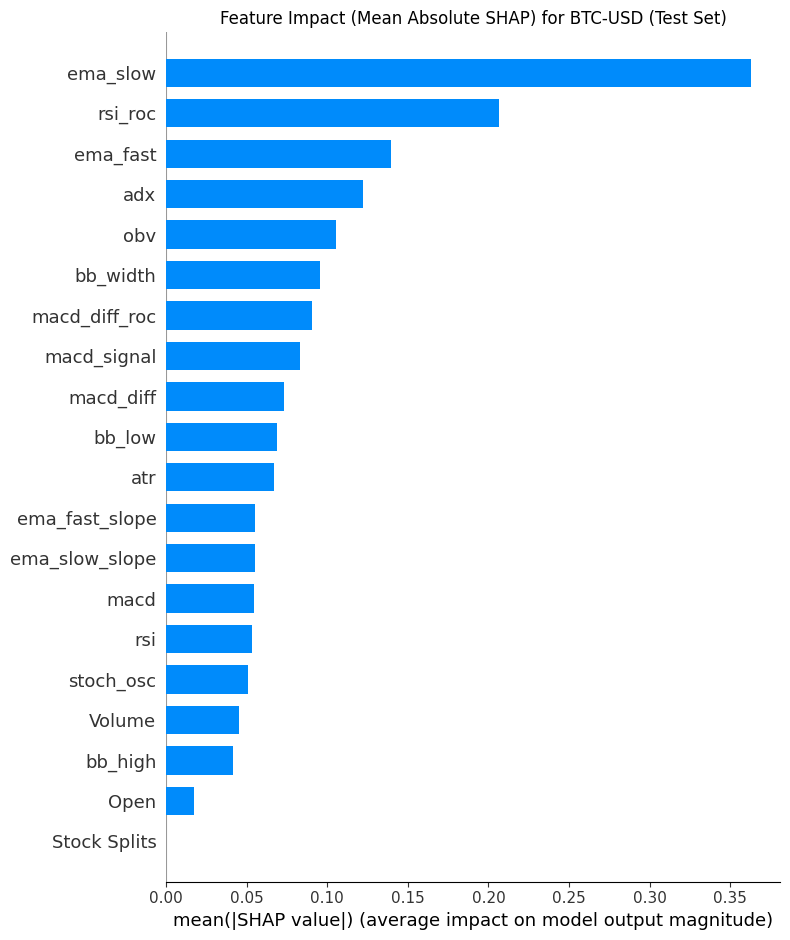

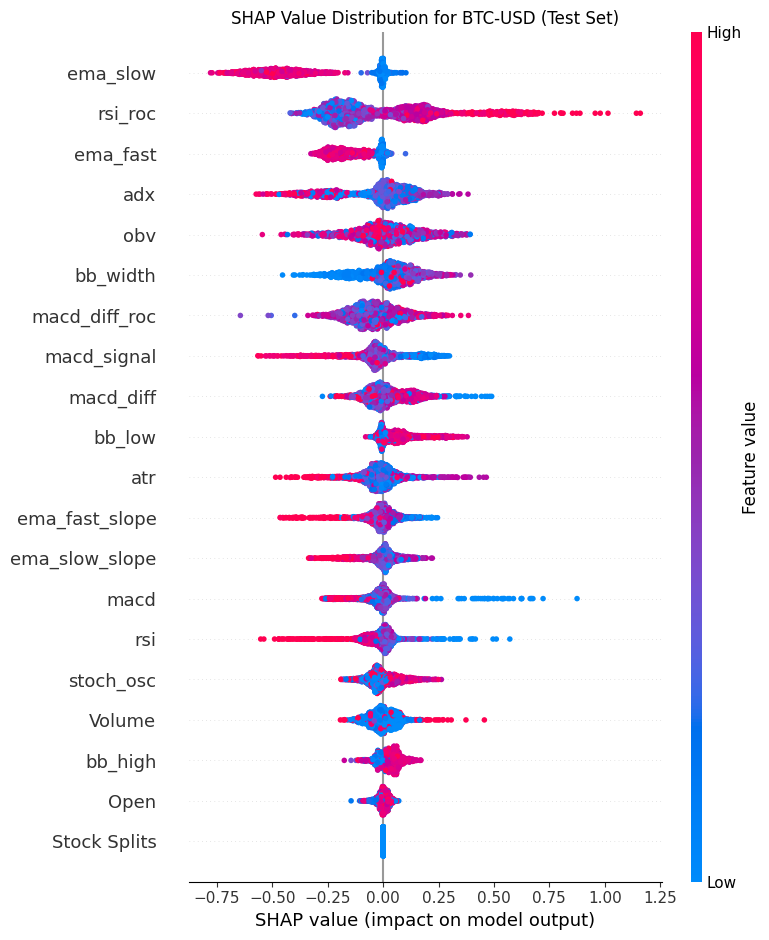

SHAP plots generated.
Generating LGBM feature importance plot...


LGBM feature importance plot generated.
                                   Open          High           Low  \
Datetime                                                              
2025-04-20 16:27:00+00:00  84515.304688  84515.304688  84515.304688   
2025-04-20 16:28:00+00:00  84527.312500  84527.312500  84527.312500   
2025-04-20 16:29:00+00:00  84535.906250  84535.906250  84535.906250   
2025-04-20 16:30:00+00:00  84535.906250  84535.906250  84535.906250   
2025-04-20 16:31:00+00:00  84510.664062  84510.664062  84510.664062   
...                                 ...           ...           ...   
2025-04-22 02:07:00+00:00  88601.234375  88601.234375  88601.234375   
2025-04-22 02:08:00+00:00  88622.890625  88622.890625  88622.890625   
2025-04-22 02:09:00+00:00  88561.148438  88561.148438  88561.148438   
2025-04-22 02:10:00+00:00  88517.968750  88517.968750  88517.968750   
2025-04-22 02:12:00+00:00  88342.882812  88342.882812  88342.882812   

                                  Cl

In [20]:
my_pipeline(TICKERS[1], PERIOD, INTERVAL)